In [1]:
# 读取monitor/synthetic_mixed_rate/synthetic_mixed_rate.tsv文件

import pandas as pd
import numpy as np

def read_file(file_path='../monitor/goodput_vs_num_devices/num_devices.tsv'):
    df = pd.read_csv(file_path, sep='\t')
    # 设置df的列名
    # df.columns = ["exp_name", "num_models",
    #            "num_devices", "num_devices_per_node", "mem_budget", "total_rate", "rate_distribution",
    #            "arrival_process", "arrival_process_kwargs", "slo_scale", "duration",
    #            "policy_name", "placement", "goodput", "mode", "solver_time"]
    return df
df = read_file()

In [2]:
policies = df['policy_name'].unique()
policies

array(['heuristic-dynamic', 'dqn-dynamic', 'my-mp-ilp-dynamic',
       'sr-replace-dynamic', 'mp-search-sep', 'sr-greedy',
       'sr-replace-600', 'my-mp-ilp-replace-600', 'my-mp-ilp'],
      dtype=object)

In [3]:
# 将df中'my-mp-ilp'的值替换为'mp-ilp'
df = df.replace('my-mp-ilp', 'mp-ilp')
df = df.replace('my-mp-ilp-dynamic', 'mp-ilp-dynamic')
df = df.replace('my-mp-ilp-replace-600', 'mp-ilp-replace-600')

In [4]:
df.head()

,exp_name,num_models,model_groups_num,num_devices,num_devices_per_node,mem_budget,total_rate,rate_distribution,arrival_process,arrival_process_kwargs,slo_scale,duration,policy_name,placement,goodput,mode,solver_time
0,goodput_vs_num_devices,12,2,4,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=1),0.374,simulate,1.609
1,goodput_vs_num_devices,12,2,8,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=50),0.643,simulate,0.000
2,goodput_vs_num_devices,12,2,12,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=33),0.852,simulate,0.001
3,goodput_vs_num_devices,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=14),0.954,simulate,0.003
4,goodput_vs_num_devices,12,2,20,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=22),0.984,simulate,0.003


In [5]:
policies = df['policy_name'].unique()
print(policies)

['heuristic-dynamic' 'dqn-dynamic' 'mp-ilp-dynamic' 'sr-replace-dynamic'
 'mp-search-sep' 'sr-greedy' 'sr-replace-600' 'mp-ilp-replace-600'
 'mp-ilp']


输出图表到 goodput_vs_num_devices.png


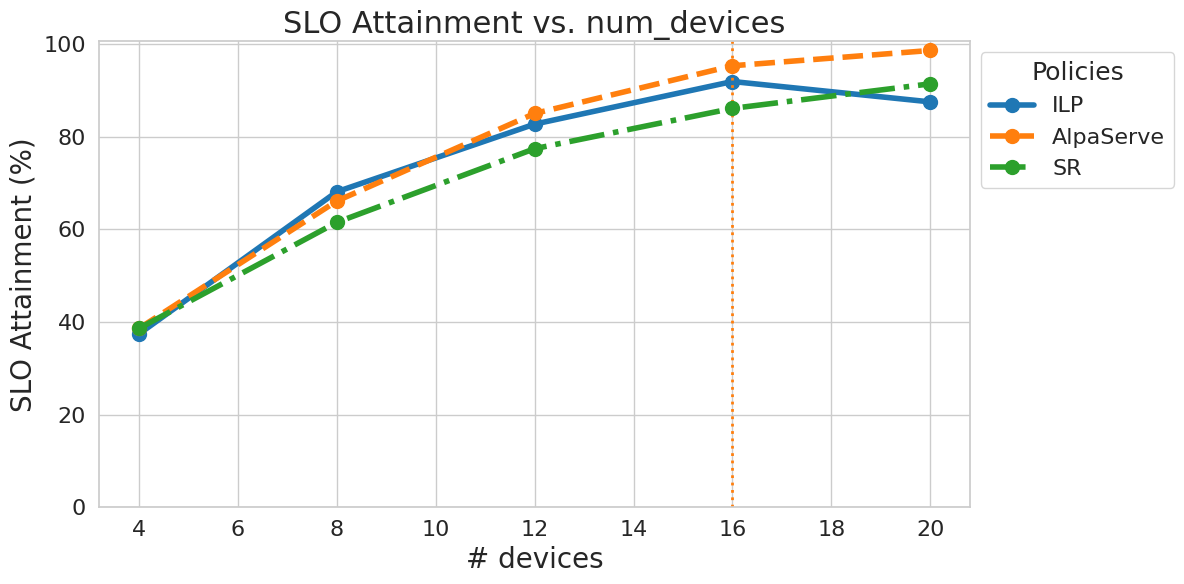

输出图表到 goodput_vs_num_devices.png


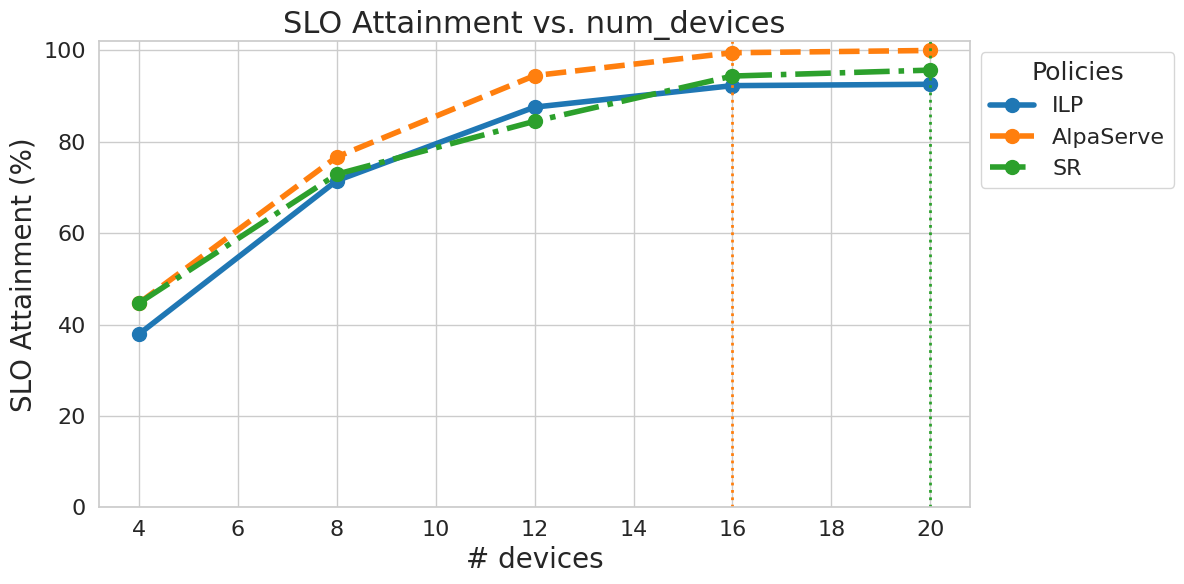

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np

# 假设这些辅助函数和变量已经定义
def method2order(method):
    # 定义方法的排序逻辑
    order = {
        "heuristic-dynamic": 1,
        "dqn-dynamic": 2,
        "mp-ilp-dynamic": 3,
        "sr-replace-dynamic": 4,
        'mp-ilp': 5,
        'mp-search-sep': 6,
        'sr-greedy': 7,
        # 添加其他策略
    }
    return order.get(method, 99)

def show_name(method):
    # 定义方法的显示名称
    names = {
        "heuristic-dynamic": "Heuristic-Dynamic",
        "dqn-dynamic": "DQN-Dynamic",
        "mp-ilp-dynamic": "ILP-Dynamic",
        "sr-replace-dynamic": "SR-dynamic",
        'mp-ilp': 'ILP',
        'mp-search-sep': 'AlpaServe',
        'sr-greedy': 'SR',
        # 添加其他策略名称
    }
    return names.get(method, method)

# 定义颜色和线型
methodcolors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyles = ['-', '--', '-.', ':', '-', '--']

def plot_goodput_vs_target(df, policies, target, arrival_process, threshold=0.95, increasing=True, xlabel='Target Variable', output='goodput_plot.png', ybottom=0, plot_legend=False):
    """
    绘制不同策略下 Goodput 随目标变量变化的折线图，风格参考 plot_goodput_common。

    参数:
    df : DataFrame - 包含政策、目标变量和 Goodput 的数据框。
    policies : list - 策略名称列表。
    target : str - 变量目标名。
    arrival_process : str - 数据名称。
    threshold : float - SLO 达成的阈值，默认0.8。
    increasing : bool - 目标变量是递增还是递减，默认True。
    xlabel : str - X轴标签，默认'Target Variable'。
    output : str - 输出图片文件名，默认'goodput_plot.png'。
    ybottom : float - Y轴下限，默认0。
    plot_legend : bool - 是否在子图中显示标题，默认False。
    """
    # 设置整体风格
    sns.set(style="whitegrid")
    
    # 提取目标变量
    if target in ast.literal_eval(df['arrival_process_kwargs'].iloc[0]).keys():
        df[target] = df['arrival_process_kwargs'].apply(lambda x: ast.literal_eval(x)[target])

    target_list = sorted(df[target].unique())
    
    # 计算每个策略和目标的 goodput，并乘以100
    goodput_dict = {policy: [] for policy in policies}
    first_good = {policy: 0 for policy in policies}
    x_max = 0
    y_max = 0

    for policy in policies:
        for t in target_list:
            df_policy_target = df[(df.policy_name == policy) & (df[target] == t) & (df.arrival_process == arrival_process)]
            mean_goodput = df_policy_target.goodput.mean() * 100  # 转换为百分比
            goodput_dict[policy].append(mean_goodput)
        
        # 查找首次达到阈值的位置
        ys = np.array(goodput_dict[policy])
        if increasing:
            indices = range(len(ys))
        else:
            indices = reversed(range(len(ys)))
        
        for i in indices:
            if ys[i] >= threshold * 100:
                first_good[policy] = target_list[i]
                break

        x_max = max(x_max, max(target_list))
        y_max = max(y_max, max(ys))
    
    # 创建子图
    fig, ax = plt.subplots(figsize=(20, 10))

    # 绘制每个策略的曲线
    curves = []
    legends = []
    for i, policy in enumerate(sorted(policies, key=lambda x: method2order(x))):
        ax.plot(target_list, goodput_dict[policy], 
                color=methodcolors[i % len(methodcolors)], 
                linestyle=linestyles[i % len(linestyles)], 
                marker='o', linewidth=4, markersize=10, label=show_name(policy))
        curves.append(ax.lines[-1])
        legends.append(show_name(policy))
        
        # 添加阈值垂直线
        if first_good[policy] != 0:
            ax.axvline(first_good[policy], color=methodcolors[i % len(methodcolors)], linestyle=":", linewidth=2)

    # 设置轴标签和标题
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel("SLO Attainment (%)", fontsize=20)
    ax.set_title(f"SLO Attainment vs. {target}", fontsize=22)
    
    # 设置刻度字体大小
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    
    # 设置Y轴范围
    ax.set_ylim(bottom=ybottom, top=max(y_max * 1.02, 100))
    
    # 添加网格
    ax.grid(True)
    
    # 添加图例
    if plot_legend:
        ax.legend(curves, legends, title="Policies", fontsize=16, title_fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))
    else:
        ax.legend().remove()
    
    # 保存并显示图形
    fig.set_size_inches(12, 6)
    plt.tight_layout()
    plt.savefig(output, bbox_inches='tight')
    print(f"输出图表到 {output}")
    plt.show()

# 示例用法：
policies = ['mp-ilp','mp-search-sep', 'sr-greedy']
plot_goodput_vs_target(df, policies, 'num_devices', 'azure_v1', plot_legend=True, xlabel='# devices', output='goodput_vs_num_devices.png')
plot_goodput_vs_target(df, policies, 'num_devices', 'azure_v2', plot_legend=True, xlabel='# devices', output='goodput_vs_num_devices.png')

输出图表到 goodput_comparison.pdf


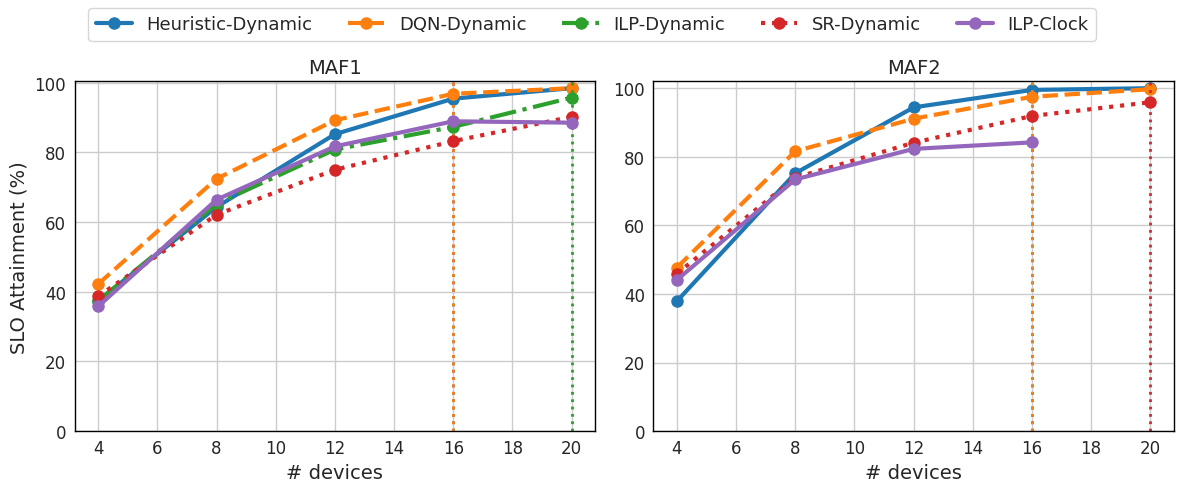

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
import pandas as pd

# 假设这些辅助函数和变量已经定义
def method2order(method):
    # 定义方法的排序逻辑
    order = {
        "heuristic-dynamic": 1,
        "dqn-dynamic": 2,
        "mp-ilp-dynamic": 3,
        "sr-replace-dynamic": 4,
        'mp-ilp': 5,
        'mp-search-sep': 6,
        'sr-greedy': 7,
        'sr-replace-600': 8,
        'mp-ilp-replace-600': 9
        # 添加其他策略
    }
    return order.get(method, 99)

def show_name(method):
    # 定义方法的显示名称
    names = {
        "heuristic-dynamic": "Heuristic-Dynamic",
        "dqn-dynamic": "DQN-Dynamic",
        "mp-ilp-dynamic": "ILP-Dynamic",
        "sr-replace-dynamic": "SR-Dynamic",
        'mp-ilp': 'ILP',
        'mp-search-sep': 'AlpaServe',
        'sr-greedy': 'SR',
        'sr-replace-600': 'Clock++',
        'mp-ilp-replace-600': 'ILP-Clock'
        # 添加其他策略名称
    }
    return names.get(method, method)

# 定义颜色和线型
methodcolors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyles = ['-', '--', '-.', ':', '-', '--']

def plot_goodput_comparison(df, policies, target, arrival_process_list, threshold=0.95, increasing=True, xlabel='Target Variable', output='goodput_comparison.png', ybottom=0, plot_legend=True):
    """
    绘制多个 arrival_process 下不同策略的 Goodput 随目标变量变化的并列折线图，并将图例放在上方。

    参数:
    df : DataFrame - 包含政策、目标变量和 Goodput 的数据框。
    policies : list - 策略名称列表。
    target : str - 变量目标名。
    arrival_process_list : list - 多个 arrival_process 名称列表。
    threshold : float - SLO 达成的阈值，默认0.95。
    increasing : bool - 目标变量是递增还是递减，默认True。
    xlabel : str - X轴标签，默认'Target Variable'。
    output : str - 输出图片文件名，默认'goodput_comparison.png'。
    ybottom : float - Y轴下限，默认0。
    plot_legend : bool - 是否显示图例，默认True。
    """
    # 设置整体风格
    sns.set(style="whitegrid")
    
    # 提取目标变量
    if target in ast.literal_eval(df['arrival_process_kwargs'].iloc[0]).keys():
        df[target] = df['arrival_process_kwargs'].apply(lambda x: ast.literal_eval(x)[target])
    
    target_list = sorted(df[target].unique())
    
    num_processes = len(arrival_process_list)
    
    # 调整每个子图的宽度，例如每个子图宽6英寸
    fig_width = 6 * num_processes
    fig, axes = plt.subplots(1, num_processes, figsize=(fig_width, 5), sharey=False)
    
    # 如果只有一个 arrival_process，则 axes 不是列表，需要转换为列表
    if num_processes == 1:
        axes = [axes]
    
    # 用于收集所有曲线和标签以创建统一的图例
    all_curves = []
    all_legends = []
    
    for ax, arrival_process in zip(axes, arrival_process_list):
        # 计算每个策略和目标的 goodput，并乘以100
        goodput_dict = {policy: [] for policy in policies}
        first_good = {policy: 0 for policy in policies}
        x_max = 0
        y_max = 0
        
        for policy in policies:
            for t in target_list:
                df_policy_target = df[(df.policy_name == policy) & (df[target] == t) & (df.arrival_process == arrival_process)]
                mean_goodput = df_policy_target.goodput.mean() * 100  # 转换为百分比
                goodput_dict[policy].append(mean_goodput)
            
            # 查找首次达到阈值的位置
            ys = np.array(goodput_dict[policy])
            if increasing:
                indices = range(len(ys))
            else:
                indices = reversed(range(len(ys)))
            
            for i in indices:
                if ys[i] >= threshold * 100:
                    first_good[policy] = target_list[i]
                    break
            
            x_max = max(x_max, max(target_list))
            y_max = max(y_max, max(ys))
        
        # 绘制每个策略的曲线
        for i, policy in enumerate(sorted(policies, key=lambda x: method2order(x))):
            curve, = ax.plot(target_list, goodput_dict[policy], 
                            color=methodcolors[i % len(methodcolors)], 
                            linestyle=linestyles[i % len(linestyles)], 
                            marker='o', linewidth=3, markersize=8, label=show_name(policy))
            if arrival_process == arrival_process_list[0]:  # 仅收集一次图例
                all_curves.append(curve)
                all_legends.append(show_name(policy))
            
            # 添加阈值垂直线
            if first_good[policy] != 0:
                ax.axvline(first_good[policy], color=methodcolors[i % len(methodcolors)], linestyle=":", linewidth=2)

            # 只在第一个子图显示y轴标签
            if ax == axes[0]:
                ax.set_ylabel("SLO Attainment (%)", fontsize=14)


        
        # 设置轴标签和标题
        ax.set_xlabel(xlabel, fontsize=14)
        # ax.set_ylabel("SLO Attainment (%)", fontsize=14)  # 每个子图显示 y 轴标签
        if arrival_process == 'azure_v1':
            ax.set_title("MAF1", fontsize=14)
        elif arrival_process == 'azure_v2':
            ax.set_title("MAF2", fontsize=14)
        
        # 设置刻度字体大小
        ax.tick_params(axis='both', which='major', labelsize=12, pad=0)
        ax.tick_params(axis='both', which='minor', labelsize=12, pad=0)
        
        # 设置Y轴范围
        ax.set_ylim(bottom=ybottom, top=max(y_max * 1.02, 100))
        
        # 添加网格
        ax.grid(True)

        # 确保边框可见
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)  # 设置边框线宽
            spine.set_color('black')  # 设置边框颜色
    
    # 设置共同的Y轴标签（可选，如果每个子图都有自己的 y 标签，可以移除此行）
    # fig.text(0.04, 0.5, "SLO Attainment (%)", va='center', rotation='vertical', fontsize=16)
    
    # 添加统一的图例在上方
    if plot_legend:
        fig.legend(all_curves, all_legends, fontsize=13, title_fontsize=14, loc='upper center', ncol=len(policies))
    
    # 调整布局，为图例留出空间
    plt.tight_layout(rect=[0, 0, 1, 0.92])  # 为图例留出顶部空间
    fig.set_size_inches(fig_width, 5)
    
    # 保存并显示图形
    plt.savefig(output, bbox_inches='tight', dpi=300)  # 增加 dpi 提高清晰度
    print(f"输出图表到 {output}")
    plt.show()

# 示例用法：
# 假设您有一个 DataFrame `df` 和一个策略列表 `policies`
# df = pd.DataFrame({...})
# policies = ['policy1', 'policy2', 'policy3']

# 调用函数绘制比较图
plot_goodput_comparison(
    df=df, 
    policies=['heuristic-dynamic','dqn-dynamic', 'mp-ilp-dynamic', 'sr-replace-dynamic', 'mp-ilp-replace-600'],
    target='num_devices', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    threshold=0.95, 
    increasing=True, 
    xlabel='# devices', 
    output='goodput_comparison.pdf', 
    ybottom=0, 
    plot_legend=True
)


输出图表到 mp_comparison.pdf


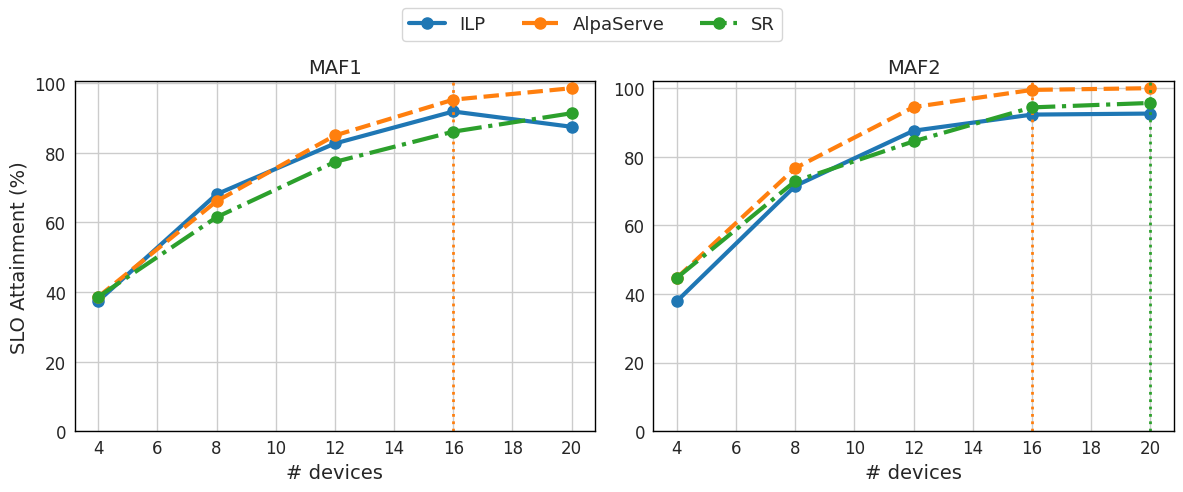

In [8]:
plot_goodput_comparison(
    df=df, 
    policies=['mp-ilp','mp-search-sep', 'sr-greedy'], 
    target='num_devices', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    threshold=0.95, 
    increasing=True, 
    xlabel='# devices', 
    output='mp_comparison.pdf', 
    ybottom=0, 
    plot_legend=True
)

输出图表到 dynamic_comparison.pdf


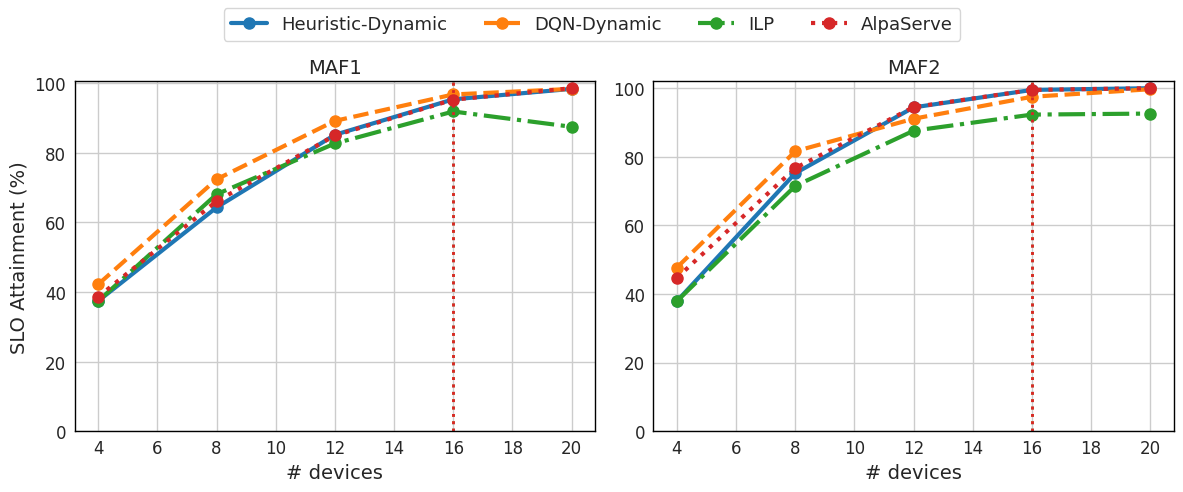

In [9]:
plot_goodput_comparison(
    df=df, 
    policies=['mp-ilp','heuristic-dynamic', 'mp-search-sep', 'dqn-dynamic'], 
    target='num_devices', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    threshold=0.95, 
    increasing=True, 
    xlabel='# devices', 
    output='dynamic_comparison.pdf', 
    ybottom=0, 
    plot_legend=True
)

In [10]:
cv_df = read_file('../monitor/goodput_vs_cv/cv.tsv')
cv_df.head()

,exp_name,num_models,model_groups_num,num_devices,num_devices_per_node,mem_budget,total_rate,rate_distribution,arrival_process,arrival_process_kwargs,slo_scale,duration,policy_name,placement,goodput,mode,solver_time
0,goodput_vs_cv_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 1, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=2),1.000,simulate,0.001
1,goodput_vs_cv_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 3, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=5),0.988,simulate,0.002
2,goodput_vs_cv_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 5, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=15),0.915,simulate,0.001
3,goodput_vs_cv_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 7, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=87),0.808,simulate,0.001
4,goodput_vs_cv_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 9, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=153),0.703,simulate,0.001


In [11]:
cv_df['policy_name'].unique()
# 将df中'my-mp-ilp'的值替换为'mp-ilp'
cv_df = cv_df.replace('my-mp-ilp', 'mp-ilp')
cv_df = cv_df.replace('my-mp-ilp-dynamic', 'mp-ilp-dynamic')
cv_df = cv_df.replace('my-mp-ilp-replace-600', 'mp-ilp-replace-600')

输出图表到 goodput_cv.pdf


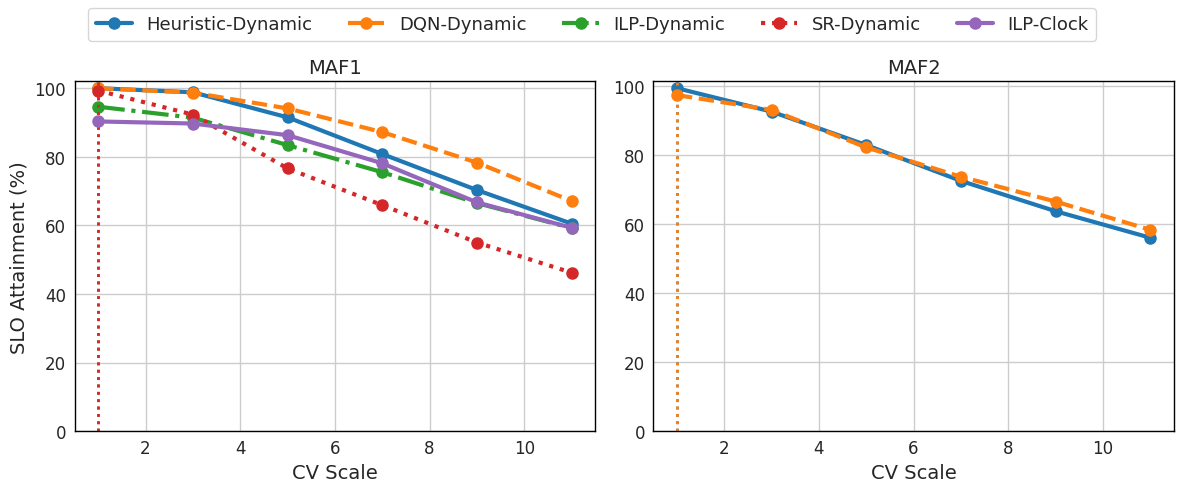

In [12]:
plot_goodput_comparison(
    df=cv_df, 
    policies=['heuristic-dynamic','dqn-dynamic', 'mp-ilp-dynamic', 'sr-replace-dynamic', 'mp-ilp-replace-600'],
    target='cv_scale', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    threshold=0.95, 
    increasing=True, 
    xlabel='CV Scale', 
    output='goodput_cv.pdf', 
    ybottom=0, 
    plot_legend=True
)

In [13]:
rate_df = read_file('../monitor/goodput_vs_rate/rate.tsv')
rate_df.head()

,exp_name,num_models,model_groups_num,num_devices,num_devices_per_node,mem_budget,total_rate,rate_distribution,arrival_process,arrival_process_kwargs,slo_scale,duration,policy_name,placement,goodput,mode,solver_time
0,goodput_vs_rate_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.001, 'cv_scale': 4, 'trace_di...",5,3600,sr-replace-dynamic,ModelPlacementWithReplacement(num_segments=12),0.959,simulate,0.006
1,goodput_vs_rate_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.001, 'cv_scale': 4, 'trace_di...",5,3600,my-mp-ilp-replace-600,ModelPlacementWithReplacement(num_segments=6),0.887,simulate,413.129
2,goodput_vs_rate_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.001, 'cv_scale': 4, 'trace_di...",5,3600,my-mp-ilp-dynamic,ModelPlacementWithReplacement(num_segments=21),0.927,simulate,68.206
3,goodput_vs_rate_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.003, 'cv_scale': 4, 'trace_di...",5,3600,sr-replace-dynamic,ModelPlacementWithReplacement(num_segments=53),0.890,simulate,0.003
4,goodput_vs_rate_scale,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.003, 'cv_scale': 4, 'trace_di...",5,3600,my-mp-ilp-replace-600,ModelPlacementWithReplacement(num_segments=6),0.924,simulate,423.101


In [14]:
rate_df['policy_name'].unique()
# 将df中'my-mp-ilp'的值替换为'mp-ilp'
rate_df = rate_df.replace('my-mp-ilp', 'mp-ilp')
rate_df = rate_df.replace('my-mp-ilp-dynamic', 'mp-ilp-dynamic')
rate_df = rate_df.replace('my-mp-ilp-replace-600', 'mp-ilp-replace-600')

输出图表到 goodput_rate.pdf


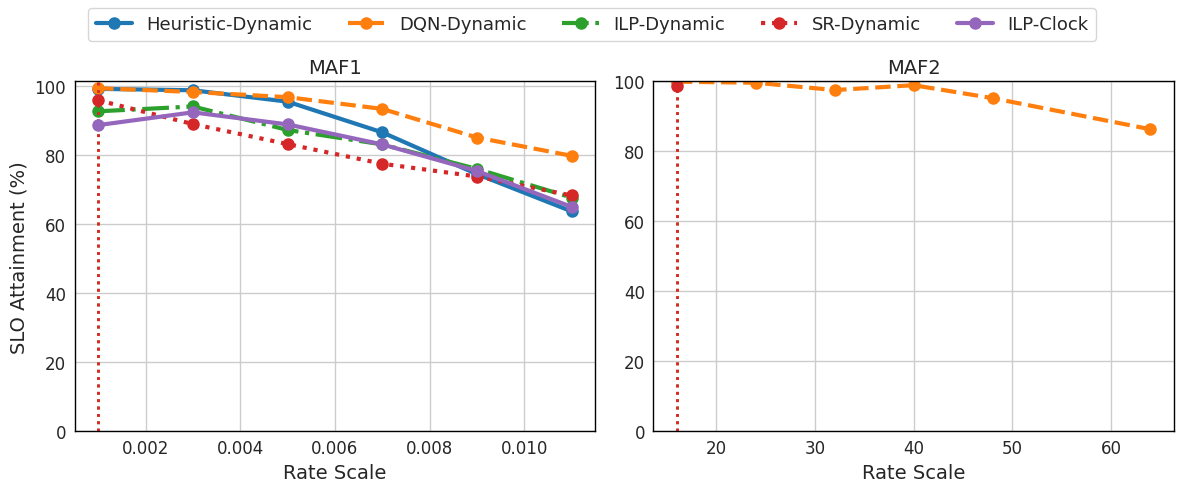

In [15]:
plot_goodput_comparison(
    df=rate_df, 
    policies=['heuristic-dynamic','dqn-dynamic', 'mp-ilp-dynamic', 'sr-replace-dynamic', 'mp-ilp-replace-600'],
    target='rate_scale', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    threshold=0.95, 
    increasing=True, 
    xlabel='Rate Scale', 
    output='goodput_rate.pdf', 
    ybottom=0, 
    plot_legend=True
)

输出图表到 goodput_comparison_bar.pdf


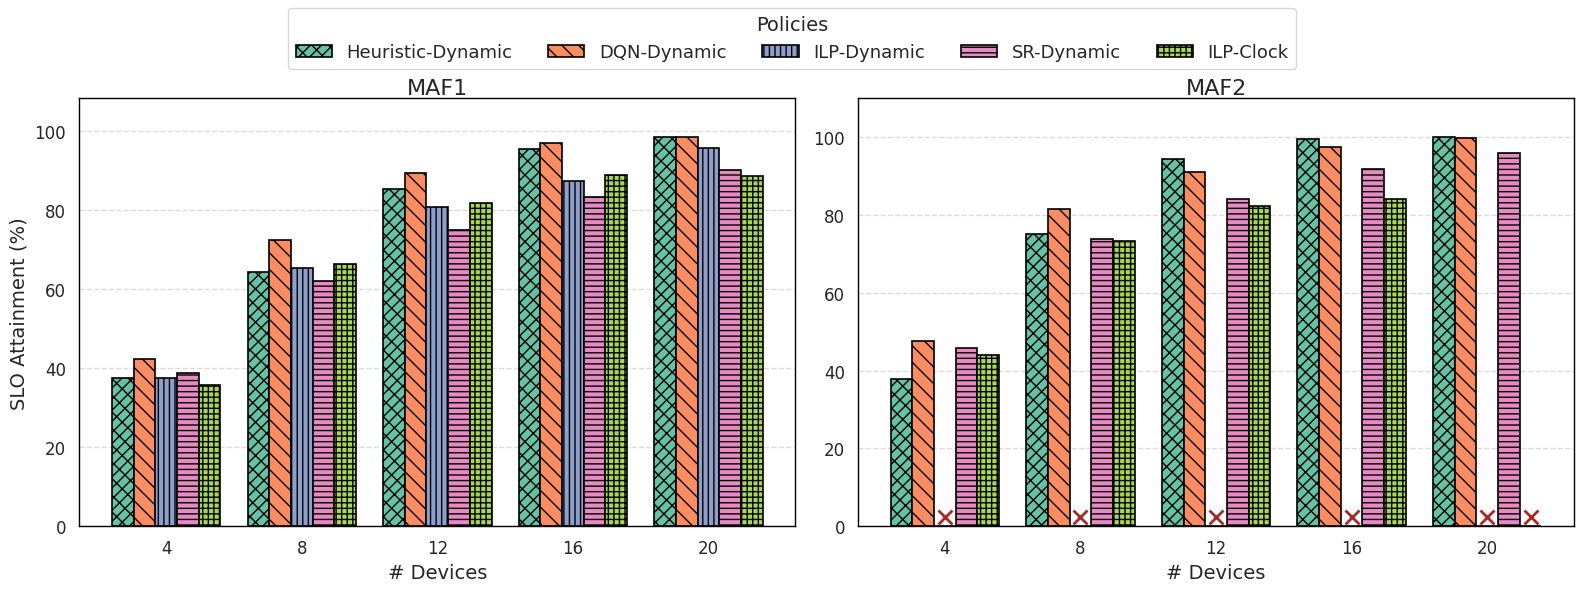

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
import pandas as pd

# 假设这些辅助函数和变量已经定义
def method2order(method):
    # 定义方法的排序逻辑
    order = {
        "heuristic-dynamic": 1,
        "dqn-dynamic": 2,
        "mp-ilp-dynamic": 3,
        "sr-replace-dynamic": 4,
        'mp-ilp': 5,
        'mp-search-sep': 6,
        'sr-greedy': 7,
        'sr-replace-600': 8,
        'mp-ilp-replace-600': 9
        # 添加其他策略
    }
    return order.get(method, 99)

def show_name(method):
    # 定义方法的显示名称
    names = {
        "heuristic-dynamic": "Heuristic-Dynamic",
        "dqn-dynamic": "DQN-Dynamic",
        "mp-ilp-dynamic": "ILP-Dynamic",
        "sr-replace-dynamic": "SR-Dynamic",
        'mp-ilp': 'ILP',
        'mp-search-sep': 'AlpaServe',
        'sr-greedy': 'SR',
        'sr-replace-600': 'Clock++',
        'mp-ilp-replace-600': 'ILP-Clock'
        # 添加其他策略名称
    }
    return names.get(method, method)

# 定义颜色和填充样式
# 使用颜色盲友好调色板
methodcolors = sns.color_palette("Set2", 10)  # 根据需要调整数量
# 增加填充样式的密度和差异性
methodhatches = ['/\/\/', '\\\\', '|||', '---', '+++', 'xxx', 'ooo', 'OOO', '...', '***']  # 更密集和差异化的填充样式

def plot_goodput_comparison_bar(df, policies, target, arrival_process_list, xlabel='Target Variable', output='goodput_comparison_bar.png', ybottom=0, plot_legend=True):
    """
    绘制多个 arrival_process 下不同策略的 Goodput 随目标变量变化的柱状图，并将图例放在上方。

    参数:
    df : DataFrame - 包含政策、目标变量和 Goodput 的数据框。
    policies : list - 策略名称列表。
    target : str - 变量目标名。
    arrival_process_list : list - 多个 arrival_process 名称列表。
    xlabel : str - X轴标签，默认'Target Variable'。
    output : str - 输出图片文件名，默认'goodput_comparison_bar.png'。
    ybottom : float - Y轴下限，默认0。
    plot_legend : bool - 是否显示图例，默认True。
    """
    # 设置整体风格
    sns.set(style="whitegrid")

    # 提取目标变量
    if target in ast.literal_eval(df['arrival_process_kwargs'].iloc[0]).keys():
        df[target] = df['arrival_process_kwargs'].apply(lambda x: ast.literal_eval(x)[target])

    target_list = sorted(df[target].unique())

    num_processes = len(arrival_process_list)

    # 调整每个子图的宽度，例如每个子图宽6英寸
    fig_width = 8 * num_processes
    fig, axes = plt.subplots(1, num_processes, figsize=(fig_width, 6), sharey=False)

    # 如果只有一个 arrival_process，则 axes 不是列表，需要转换为列表
    if num_processes == 1:
        axes = [axes]

    # 用于收集所有柱状图和标签以创建统一的图例
    all_bars = []
    all_legends = []

    # 定义每组柱状图的宽度和位置
    bar_width = 0.8 / len(policies)  # 让所有策略的柱状图总宽度不超过0.8
    x = np.arange(len(target_list))  # 目标变量的位置

    for ax, arrival_process in zip(axes, arrival_process_list):
        # 计算每个策略和目标的 goodput，并乘以100
        goodput_dict = {policy: [] for policy in policies}
        y_max = 0

        for policy in policies:
            for t in target_list:
                df_policy_target = df[(df.policy_name == policy) & (df[target] == t) & (df.arrival_process == arrival_process)]
                if not df_policy_target.empty:
                    mean_goodput = df_policy_target.goodput.mean() * 100  # 转换为百分比
                else:
                    mean_goodput = np.nan  # 使用 NaN 表示缺失数据
                goodput_dict[policy].append(mean_goodput)

            # 更新 y_max
            current_max = max([val for val in goodput_dict[policy] if not np.isnan(val)] + [0])
            y_max = max(y_max, current_max)

        # 绘制每个策略的柱状图
        for i, policy in enumerate(sorted(policies, key=lambda x: method2order(x))):
            # 计算每个柱的位置
            offset = (i - len(policies)/2) * bar_width + bar_width/2
            bar_positions = x + offset

            # 提取当前策略的 goodput 数据
            goodput_values = goodput_dict[policy]

            # 绘制柱状图，处理缺失数据
            bars = ax.bar(bar_positions, 
                          [val if not np.isnan(val) else 0 for val in goodput_values],
                          width=bar_width,
                          color=methodcolors[i % len(methodcolors)],
                          hatch=methodhatches[i % len(methodhatches)],
                          label=show_name(policy),
                          edgecolor='black',
                          linewidth=1.2)

            # 记录图例
            if arrival_process == arrival_process_list[0]:
                all_bars.append(bars[0])
                all_legends.append(show_name(policy))

            # 添加“×”标记表示缺失数据，稍微上移避免与 x 轴重叠
            for j, val in enumerate(goodput_values):
                if np.isnan(val):
                    # 将“×”标记放置在柱子顶部的 5% 位置
                    ax.plot(bar_positions[j], ybottom + (y_max * 0.025), marker='x', color='brown', markersize=10, markeredgewidth=2)

        # 设置轴标签和标题
        ax.set_xlabel(xlabel, fontsize=14)

        # 仅在第一个子图显示y轴标签
        if ax == axes[0]:
            ax.set_ylabel("SLO Attainment (%)", fontsize=14)

        # 设置标题
        if arrival_process == 'azure_v1':
            ax.set_title("MAF1", fontsize=16, pad=3)
        elif arrival_process == 'azure_v2':
            ax.set_title("MAF2", fontsize=16, pad=3)
        else:
            ax.set_title(show_name(arrival_process), fontsize=16, pad=15)

        # 设置x轴刻度
        ax.set_xticks(x)
        ax.set_xticklabels(target_list, fontsize=12)

        # 设置y轴刻度
        ax.tick_params(axis='y', which='major', labelsize=12)

        # 设置Y轴范围
        ax.set_ylim(bottom=ybottom, top=max(y_max * 1.10, 100))  # 增加10%空间

        # 仅显示横向网格线
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # 移除竖向网格线
        ax.grid(False, axis='x')

        # 确保边框可见
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)  # 设置边框线宽
            spine.set_color('black')  # 设置边框颜色

    # 添加统一的图例在上方
    if plot_legend:
        fig.legend(all_bars, all_legends, fontsize=13, title="Policies", title_fontsize=14, loc='upper center', ncol=len(policies))

    # 调整布局，为图例留出空间
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # 为图例留出顶部空间
    fig.set_size_inches(fig_width, 6)

    # 保存并显示图形
    plt.savefig(output, bbox_inches='tight', dpi=300)  # 增加 dpi 提高清晰度
    print(f"输出图表到 {output}")
    plt.show()

# 示例用法：
# 假设您有一个 DataFrame `df` 和一个策略列表 `policies`
# df = pd.DataFrame({...})
# policies = ['policy1', 'policy2', 'policy3']

# 调用函数绘制比较图
plot_goodput_comparison_bar(
    df=df, 
    policies=['heuristic-dynamic','dqn-dynamic', 'mp-ilp-dynamic', 'sr-replace-dynamic', 'mp-ilp-replace-600'],
    target='num_devices', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    xlabel='# Devices', 
    output='goodput_comparison_bar.pdf', 
    ybottom=0, 
    plot_legend=True
)

输出图表到 solver_time_comparison_bar.pdf


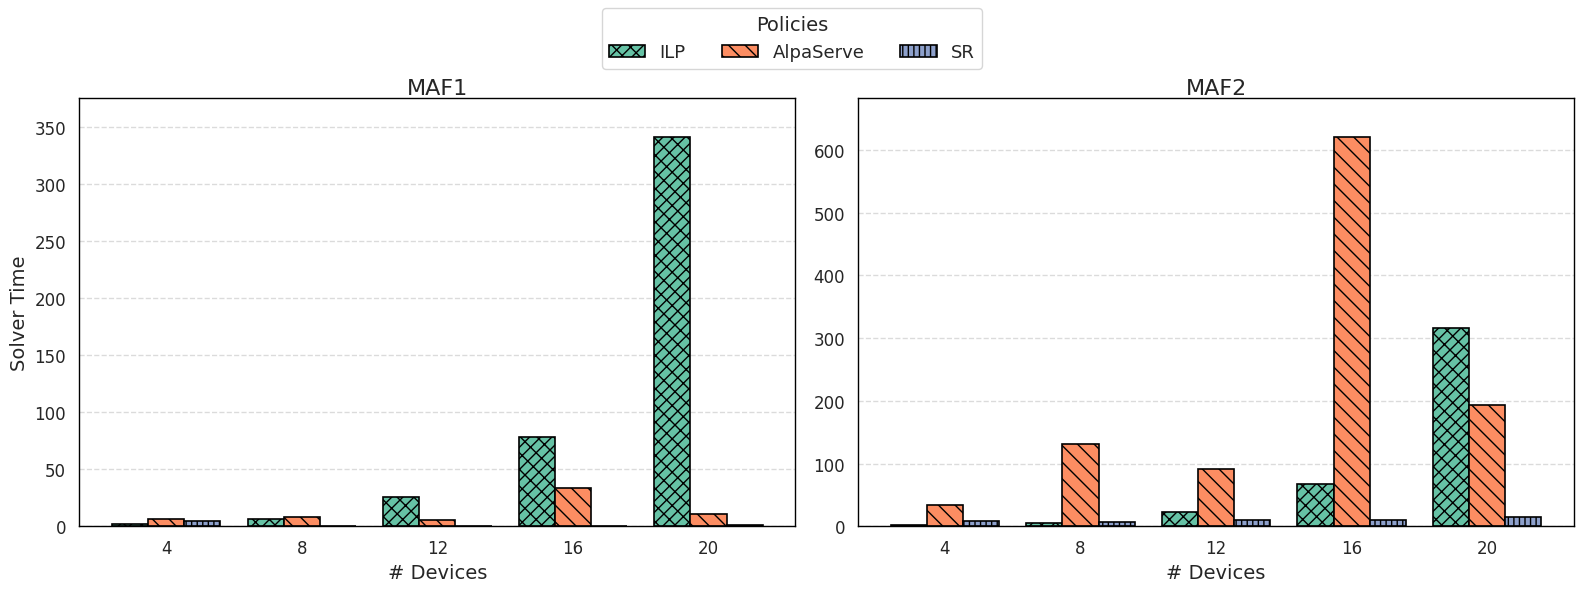

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
import pandas as pd

# 定义方法的排序逻辑
def method2order(method):
    order = {
        "heuristic-dynamic": 1,
        "dqn-dynamic": 2,
        "mp-ilp-dynamic": 3,
        "sr-replace-dynamic": 4,
        'mp-ilp': 5,
        'mp-search-sep': 6,
        'sr-greedy': 7,
        'sr-replace-600': 8,
        'mp-ilp-replace-600': 9
        # 添加其他策略
    }
    return order.get(method, 99)

# 定义方法的显示名称
def show_name(method):
    names = {
        "heuristic-dynamic": "Heuristic-Dynamic",
        "dqn-dynamic": "DQN-Dynamic",
        "mp-ilp-dynamic": "ILP-Dynamic",
        "sr-replace-dynamic": "SR-Dynamic",
        'mp-ilp': 'ILP',
        'mp-search-sep': 'AlpaServe',
        'sr-greedy': 'SR',
        'sr-replace-600': 'Clock++',
        'mp-ilp-replace-600': 'ILP-Clock'
        # 添加其他策略名称
    }
    return names.get(method, method)

# 定义颜色和填充样式
# 使用颜色盲友好调色板
methodcolors = sns.color_palette("Set2", 10)  # 根据需要调整数量
# 增加填充样式的密度和差异性
methodhatches = ['/\/\/', '\\\\', '|||', '---', '+++', 'xxx', 'ooo', 'OOO', '...', '***']  # 更密集和差异化的填充样式

def plot_time_comparison_bar(df, policies, target, arrival_process_list, xlabel='Target Variable', output='solver_time_comparison_bar.png', ybottom=0, plot_legend=True):
    """
    绘制多个 arrival_process 下不同策略的 Solver Time 随目标变量变化的柱状图，并将图例放在上方。

    参数:
    df : DataFrame - 包含政策、目标变量和 Solver Time 的数据框。
    policies : list - 策略名称列表。
    target : str - 变量目标名。
    arrival_process_list : list - 多个 arrival_process 名称列表。
    xlabel : str - X轴标签，默认'Target Variable'。
    output : str - 输出图片文件名，默认'solver_time_comparison_bar.png'。
    ybottom : float - Y轴下限，默认0。
    plot_legend : bool - 是否显示图例，默认True。
    """
    # 设置整体风格
    sns.set(style="whitegrid")

    # 提取目标变量
    if target in ast.literal_eval(df['arrival_process_kwargs'].iloc[0]).keys():
        df[target] = df['arrival_process_kwargs'].apply(lambda x: ast.literal_eval(x)[target])

    target_list = sorted(df[target].unique())

    num_processes = len(arrival_process_list)

    # 调整每个子图的宽度，例如每个子图宽8英寸
    fig_width = 8 * num_processes
    fig, axes = plt.subplots(1, num_processes, figsize=(fig_width, 6), sharey=False)

    # 如果只有一个 arrival_process，则 axes 不是列表，需要转换为列表
    if num_processes == 1:
        axes = [axes]

    # 用于收集所有柱状图和标签以创建统一的图例
    all_bars = []
    all_legends = []

    # 定义每组柱状图的宽度和位置
    bar_width = 0.8 / len(policies)  # 让所有策略的柱状图总宽度不超过0.8
    x = np.arange(len(target_list))  # 目标变量的位置

    for ax, arrival_process in zip(axes, arrival_process_list):
        # 计算每个策略和目标的 Solver Time
        solver_time_dict = {policy: [] for policy in policies}
        y_max = 0

        for policy in policies:
            for t in target_list:
                df_policy_target = df[(df.policy_name == policy) & (df[target] == t) & (df.arrival_process == arrival_process)]
                if not df_policy_target.empty:
                    mean_solver_time = df_policy_target.solver_time.mean()
                else:
                    mean_solver_time = np.nan  # 使用 NaN 表示缺失数据
                solver_time_dict[policy].append(mean_solver_time)

            # 更新 y_max
            current_max = max([val for val in solver_time_dict[policy] if not np.isnan(val)] + [0])
            y_max = max(y_max, current_max)

        # 绘制每个策略的柱状图
        for i, policy in enumerate(sorted(policies, key=lambda x: method2order(x))):
            # 计算每个柱的位置
            offset = (i - len(policies)/2) * bar_width + bar_width/2
            bar_positions = x + offset

            # 提取当前策略的 Solver Time 数据
            solver_time_values = solver_time_dict[policy]

            # 绘制柱状图，处理缺失数据
            bars = ax.bar(bar_positions, 
                          [val if not np.isnan(val) else 0 for val in solver_time_values],
                          width=bar_width,
                          color=methodcolors[i % len(methodcolors)],
                          hatch=methodhatches[i % len(methodhatches)],
                          label=show_name(policy),
                          edgecolor='black',
                          linewidth=1.2)

            # 记录图例
            if arrival_process == arrival_process_list[0]:
                all_bars.append(bars[0])
                all_legends.append(show_name(policy))

            # 添加“×”标记表示缺失数据，稍微上移避免与 x 轴重叠
            for j, val in enumerate(solver_time_values):
                if np.isnan(val):
                    # 将“×”标记放置在 y=5% 的位置，确保不与 x 轴重叠
                    ax.plot(bar_positions[j], ybottom + (y_max * 0.05), marker='x', color='brown', markersize=10, markeredgewidth=2)

        # 设置轴标签和标题
        ax.set_xlabel(xlabel, fontsize=14)

        # 仅在第一个子图显示y轴标签
        if ax == axes[0]:
            ax.set_ylabel("Solver Time", fontsize=14)

        # 设置标题
        if arrival_process == 'azure_v1':
            ax.set_title("MAF1", fontsize=16, pad=3)
        elif arrival_process == 'azure_v2':
            ax.set_title("MAF2", fontsize=16, pad=3)
        else:
            ax.set_title(show_name(arrival_process), fontsize=16, pad=3)

        # 设置x轴刻度
        ax.set_xticks(x)
        ax.set_xticklabels(target_list, fontsize=12)

        # 设置y轴刻度
        ax.tick_params(axis='y', which='major', labelsize=12)

        # 设置Y轴范围
        ax.set_ylim(bottom=ybottom, top=max(y_max * 1.10, 100))  # 增加10%空间

        # 仅显示横向网格线
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # 移除竖向网格线
        ax.grid(False, axis='x')

        # 确保边框可见
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)  # 设置边框线宽
            spine.set_color('black')  # 设置边框颜色

    # 添加统一的图例在上方
    if plot_legend:
        fig.legend(all_bars, all_legends, fontsize=13, title="Policies", title_fontsize=14, loc='upper center', ncol=len(policies))

    # 调整布局，为图例留出空间
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # 为图例留出顶部空间
    fig.set_size_inches(fig_width, 6)

    # 保存并显示图形
    plt.savefig(output, bbox_inches='tight', dpi=300)  # 增加 dpi 提高清晰度
    print(f"输出图表到 {output}")
    plt.show()

# 示例用法：
# 假设您有一个 DataFrame `df` 和一个策略列表 `policies`
# df = pd.DataFrame({...})
# policies = ['policy1', 'policy2', 'policy3']

# 调用函数绘制比较图
plot_time_comparison_bar(
    df=df, 
    policies=['mp-ilp', 'mp-search-sep', 'sr-greedy'],
    target='num_devices', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    xlabel='# Devices', 
    output='solver_time_comparison_bar.pdf', 
    ybottom=0, 
    plot_legend=True
)


In [21]:
motivation_df = read_file('../monitor/motivation_goodput_vs_num_devices_cv/motivation.tsv')
motivation_df.head()

,exp_name,num_models,model_groups_num,num_devices,num_devices_per_node,mem_budget,total_rate,rate_distribution,arrival_process,arrival_process_kwargs,slo_scale,duration,policy_name,placement,goodput,mode,solver_time
0,motivation_goodput_vs_num_devices_cv,12,2,8,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 1, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=4),0.705,simulate,0.001
1,motivation_goodput_vs_num_devices_cv,12,2,8,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 5, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=69),0.601,simulate,0.000
2,motivation_goodput_vs_num_devices_cv,12,2,8,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 9, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=119),0.418,simulate,0.001
3,motivation_goodput_vs_num_devices_cv,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 1, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=2),1.000,simulate,0.001
4,motivation_goodput_vs_num_devices_cv,12,2,16,8,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 5, 'trace_di...",5,3600,heuristic-dynamic,ModelPlacementWithReplacement(num_segments=15),0.915,simulate,0.001


In [22]:
motivation_df['policy_name'].unique()
# 将df中'my-mp-ilp'的值替换为'mp-ilp'
# rate_df = rate_df.replace('my-mp-ilp', 'mp-ilp')
# rate_df = rate_df.replace('my-mp-ilp-dynamic', 'mp-ilp-dynamic')
# rate_df = rate_df.replace('my-mp-ilp-replace-600', 'mp-ilp-replace-600')

array(['heuristic-dynamic', 'sr-replace-60', 'mp-search-sep',
       'mp-search-sep-replace-60'], dtype=object)

输出图表到 motivation_bar.pdf


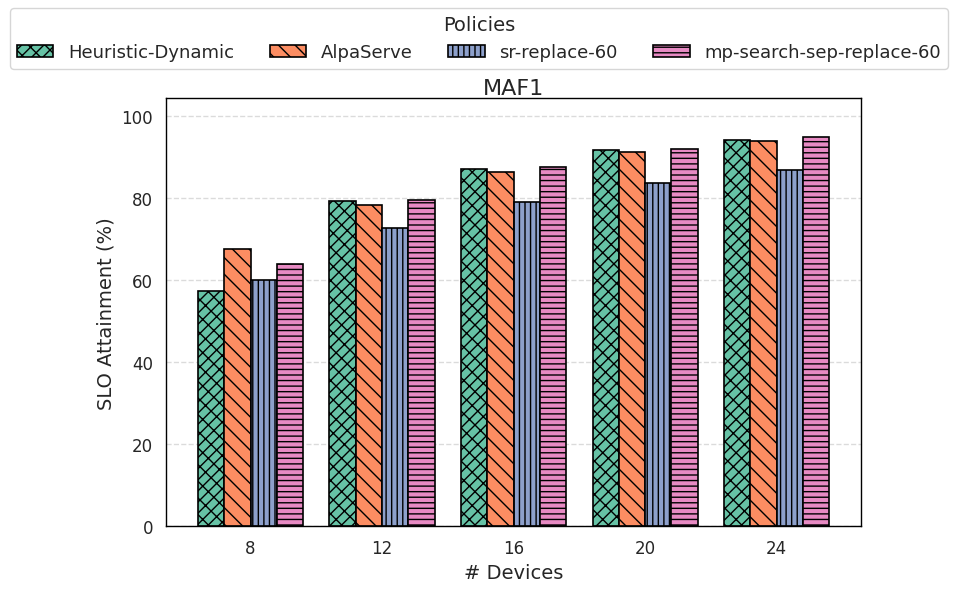

In [23]:
plot_goodput_comparison_bar(
    df=motivation_df, 
    policies=['heuristic-dynamic', 'sr-replace-60', 'mp-search-sep','mp-search-sep-replace-60'],
    target='num_devices', 
    arrival_process_list=['azure_v1'], 
    xlabel='# Devices', 
    output='motivation_bar.pdf', 
    ybottom=0, 
    plot_legend=True
)

In [18]:
def plot_solver_time_by_target(df, policies, target):
    """
    绘制不同目标下每个策略的 solver_time 的柱状图。

    参数:
    df : DataFrame - 包含政策、目标变量和 solver_time 的数据框。
    policies : list - 策略名称列表。
    target : str - 变量目标名。
    """
    # Set the style for the plot
    sns.set(style="whitegrid")

    if target in ast.literal_eval(df['arrival_process_kwargs'][0]).keys():
        # 创建新的列，列名为target，列值为ast.literal_eval(df['arrival_process_kwargs'][target])
        df[target] = df['arrival_process_kwargs'].apply(lambda x: ast.literal_eval(x)[target])

    # 只选择包含目标和政策的行
    df = df[df['policy_name'].isin(policies)]

    # Calculate mean solver_time for each policy and target
    mean_solver_time = df.groupby(['policy_name', target])['solver_time'].mean().reset_index()

    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=target, y='solver_time', hue='policy_name', data=mean_solver_time, ci=None)

    # Add labels and title
    plt.xlabel(target, fontsize=14)
    plt.ylabel("Average Solver Time", fontsize=14)
    plt.title(f"Average Solver Time by {target}", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add grid for better readability
    plt.grid(True)

    # Add legend
    plt.legend(title="Policies", fontsize=12, title_fontsize='13', loc='upper right')

    # Save the figure as a high-resolution image
    # plt.savefig("solver_time_by_target.png", dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [19]:
plot_solver_time_by_target(df, policies, 'cv')

KeyError: 'cv'

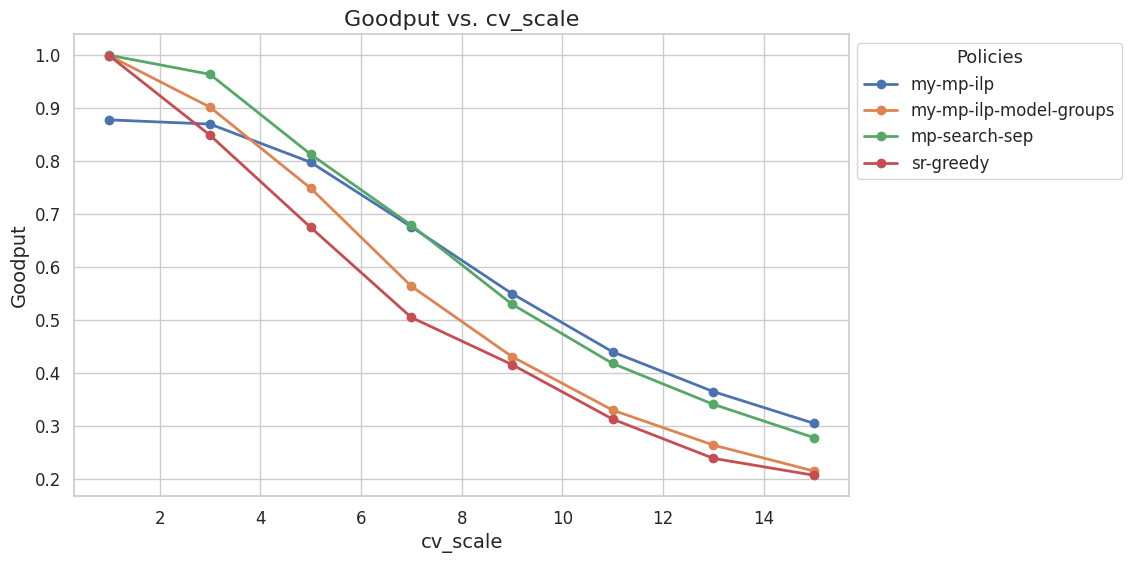

In [18]:
df = read_synthetic_mixed_rate(file_path='../monitor/goodput_vs_cv_group_models/group_models_azure_v1.tsv')
df = df[df['exp_name'] == 'goodput_vs_cv_scale']
policies = df['policy_name'].unique()
plot_goodput_vs_target(df, policies, "cv_scale")

/tmp/ipykernel_45275/2028839683.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=target, y='solver_time', hue='policy_name', data=mean_solver_time, ci=None)


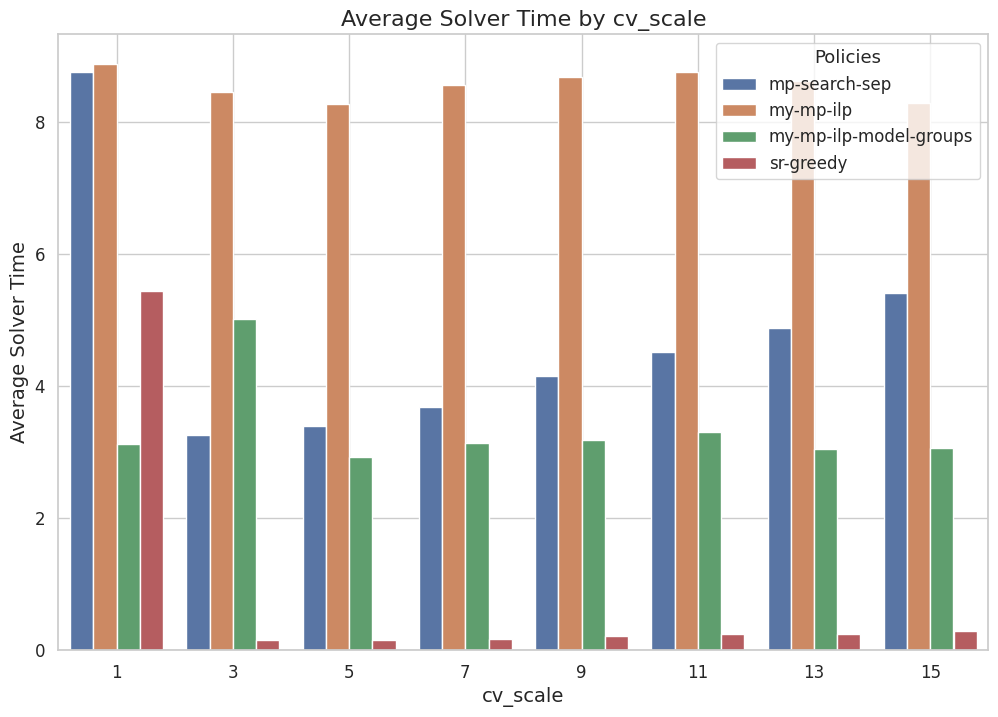

In [19]:
plot_solver_time_by_target(df, policies, 'cv_scale')

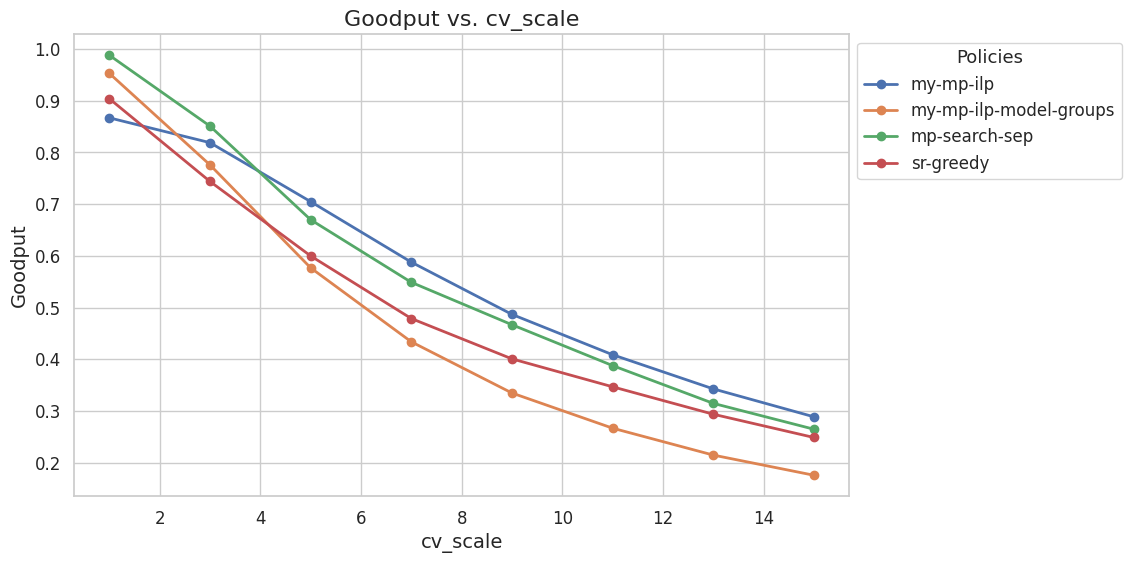

In [20]:
df = read_synthetic_mixed_rate(file_path='../monitor/goodput_vs_cv_group_models/group_models_azure_v2.tsv')
df = df[df['exp_name'] == 'goodput_vs_cv_scale']
policies = df['policy_name'].unique()
plot_goodput_vs_target(df, policies, "cv_scale")

/tmp/ipykernel_45275/2028839683.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=target, y='solver_time', hue='policy_name', data=mean_solver_time, ci=None)


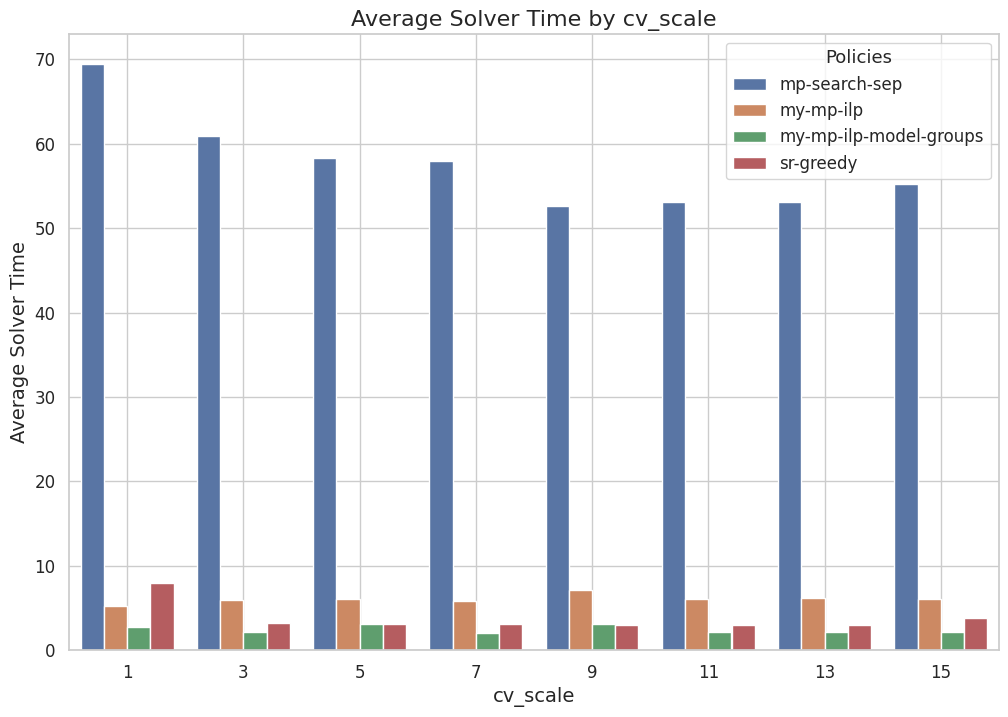

In [21]:
plot_solver_time_by_target(df, policies, 'cv_scale')

问题发现：
在低请求量和请求量均匀的情况下，模型进行分组对集群总的goodput性能的增益更好。

问题解释：
若模型分组，模型只能用到一部分的集群资源，通过并行放置得到的增益会减少，在低请求量和请求量均匀时模型分组能够通过优化资源的分配和提高负载均衡来增强集群的 overall goodput，但在高请求量和请求量不均匀时无法更好地利用集群资源通过并行提高性能增益。